This file attempts to read the relevant TLEF data and make simple bar charts. This is a work in progress.

# Preparing the data

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from tabulate import tabulate
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 10,4
CMAP = ['cornflowerblue','#fc8d62','#a6d854','#b3b3b3','#e78ac3','#66c2a5','#ffd92f']
mpl.rcParams['axes.color_cycle'] = CMAP
seq_palette = sns.cubehelix_palette(10, start=0, rot=0, dark=0.35, light=0.95, as_cmap=True)
#  ["#3498db","#9b59b6", "#e74c3c","#95a5a6", "#34495e", "#2ecc71"] #flatui
# pd.options.mode.chained_assignment = None #removed annoying pandas warning when making chained assigment
pd.set_option("display.max_columns",101)

C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Loading the data

In [3]:
excel_data = pd.ExcelFile("data/TLEF Impact Data.xlsx")

In [4]:
df_focus = excel_data.parse("Focus & Context")
df_evidence = excel_data.parse("Evidence & Sustainment",skiprows=1)

## Grabbing the categories

In [5]:
with open("data/categories.txt",'r') as f:
    categories = f.readlines()
categories = [x.strip() for x in categories] #remove newline characters
short_categories = [c.split('(')[0].strip() for c in categories]

## Grabbing different types of projects

In [6]:
project_types = list(set(df_focus['Type']))
n_types = (len(project_types))

## Cleaning the data

We check that both dfs have the same project ids.

In [7]:
projects_focus = set(list(df_focus['PROJECT ID']))
projects_evidence = set(list(df_evidence['PROJECT ID']))
projects_evidence == projects_focus

True

We convert the NaN to 0 and change the "x" into 1.

In [8]:
df_focus.replace('x',1,inplace=True)
df_focus.replace('x (intership facilitation)',1,inplace=True)
df_focus.replace('NAN',0,inplace=True)
df_focus.replace('SCI','SCIE',inplace=True)

In [9]:
df_focus.head()

,PROJECT ID,Resource development (e.g. media; open resources; reading and PD materials; learning modules; apps),Infrastructure development (e.g. LMS; repositories; physical spaces),Pedagogies for student learning and/or engagement (e.g. flipped classroom; active learning; student-generated content; student choice; peer-collaboration),Teaching roles and training (e.g. co-teaching; TA roles; office hours; participation in PD),Curriculum and design (e.g. learning/course/program design; cross and trans disciplinary courses/programs; formulation of course/program learning outcomes),Innovative assessment (e.g. two-stage exams; peer-assessment; engaging assessments; student choice),Community outreach and values (e.g. community service; social networks; co-op; social inclusion and equity; indigenous; wellbeing),Test category,Other,Faculty,Type,Year,Funds received,Evaluation TLEF $ Asks
0,2013FL1_APSC_CIVL_Yonemitsu,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,APSC,FL/Large,2013,66135.0,None
1,2013FL1_APSC_NURS_Macphee,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,APSC,FL/Large,2013,254808.0,TLF
2,2013FL1_ARTS_PSYC_Barnes,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ARTS,FL/Large,2013,59806.0,None
3,2013FL1_ARTS_GRSI_Stewart,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,ARTS,FL/Large,2013,34356.0,None
4,2013FL1_ARTS_LING_Matthewson,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ARTS,FL/Large,2013,167022.0,TLF


In [10]:
df_evidence.head()

,PROJECT ID,Student learning and knowledge,Student engagement and attitudes,Instructional team teaching practice and satisfaction,Other,Operations & Department capacity,Influence in priorities/direction,Other.1,Courses and programs,Resources and infrastructure,Scholarly contributions,Other.2,Project sustainment after closure,Expansion beyond original plan,Other.3,Evaluation TLEF $ Asks
0,2013FL1_APSC_CIVL_Yonemitsu,Evidence,Evidence,Evidence,No information,Evidence,No information,No information,No information,Faculty,No information,No information,Evidence,Ideas,No information,None
1,2013FL1_APSC_NURS_Macphee,Evidence,Evidence,Evidence,No information,Evidence,Evidence,No information,Unit,Unit,External,No information,Evidence,No information,No information,TLF
2,2013FL1_ARTS_PSYC_Barnes,Evidence,Anecdotal,Evidence,No information,No information,Evidence,No information,Faculty,Faculty,External,No information,Evidence,Evidence,No information,None
3,2013FL1_ARTS_GRSI_Stewart,No information,Anecdotal,Evidence,No information,No information,No information,No information,No information,Single course,No information,No information,Ideas,No information,No information,None
4,2013FL1_ARTS_LING_Matthewson,No information,Evidence,Evidence,No information,Evidence,No information,No information,Multi course,Multi course,UBC,No information,Ideas,Ideas,No information,TLF


## Creating xlsx file with generated tables

In [11]:
path = r"tlef_data_generated_analysis_tables.xlsx"
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

# Descriptives

In [12]:
N = len(projects_evidence)
type_with_most_projects = project_types[0]
n_most = 0
print "There are {0} projects to analyze and {1} types of projects:".format(N,n_types)
for t in project_types:
    n = len(df_focus[df_focus['Type']==t])
    if n >1: plural = 's'
    else: plural = ''
    print "    {0} {1} project{2},".format(n,t,plural)
    if n_most < n:
        n_most = n
        type_with_most_projects = t


There are 77 projects to analyze and 2 types of projects:
    53 Small projects,
    24 FL/Large projects,


In [13]:
table = df_focus['Type'].value_counts()
table = pd.DataFrame(table)
table.index.names = ['Number of projects per type']
table.rename(columns={'Type':'Number of projects'}).to_excel(writer, sheet_name = 'number_projects_per_type')

## How much funding does a project typically get?

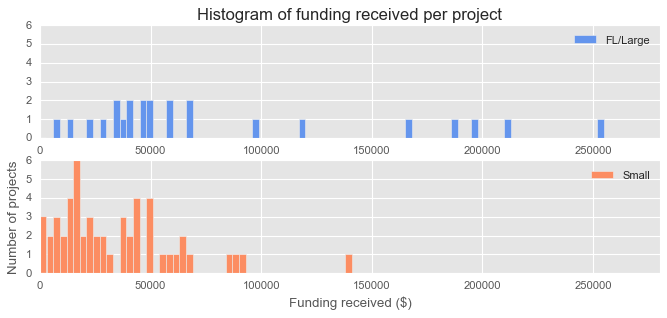

In [14]:
fig,axes = plt.subplots(nrows=n_types,ncols=1,figsize=(10,2*n_types))
ymaximum = 0
for i,(ax,size) in enumerate(zip(axes,sorted(project_types))):
    df_focus[df_focus['Type']==size]['Funds received'].hist(bins=range(0,300000,3000),ax=ax,label=size,color=CMAP[i])
    ax.set_xlim((0,max(df_focus['Funds received'])*1.1))
    ax.legend()
    ymaximum = max(ymaximum, ax.get_ylim()[1])
ax.set_xlabel('Funding received ($)',fontsize=12);ax.set_ylabel('Number of projects',fontsize=12)
axes[0].set_title("Histogram of funding received per project",fontsize=15);
for ax in axes:
    ax.set_ylim((0,ymaximum))

Projects with lots of funding tend to be Large TLEF projects but not necessarily the reverse. In fact, many large projects get little funding, probably because they are FL projects.

Here is the project that is "small" but has 140 000 in funding:

In [15]:
df_focus[(df_focus['Funds received']>100000)&(df_focus['Type']=='Small')]

,PROJECT ID,Resource development (e.g. media; open resources; reading and PD materials; learning modules; apps),Infrastructure development (e.g. LMS; repositories; physical spaces),Pedagogies for student learning and/or engagement (e.g. flipped classroom; active learning; student-generated content; student choice; peer-collaboration),Teaching roles and training (e.g. co-teaching; TA roles; office hours; participation in PD),Curriculum and design (e.g. learning/course/program design; cross and trans disciplinary courses/programs; formulation of course/program learning outcomes),Innovative assessment (e.g. two-stage exams; peer-assessment; engaging assessments; student choice),Community outreach and values (e.g. community service; social networks; co-op; social inclusion and equity; indigenous; wellbeing),Test category,Other,Faculty,Type,Year,Funds received,Evaluation TLEF $ Asks
56,14-087-Loewen-Final,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,PHAR,Small,2014,140936.0,10000


## Which faculties are most represented?

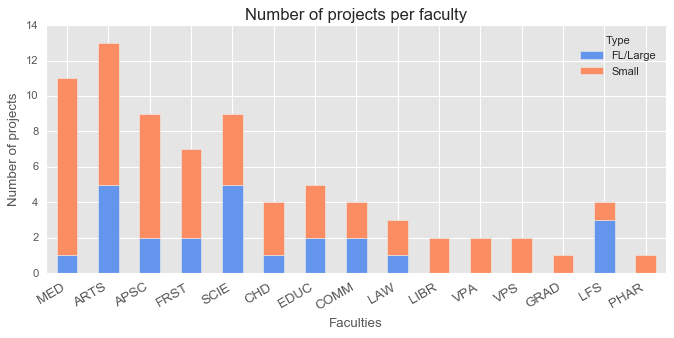

In [16]:
table = df_focus.groupby('Faculty')['Type'].value_counts().unstack().sort_values(type_with_most_projects,ascending=False)
table.plot(kind='bar',stacked=True)
ax = plt.subplot();ax.set_xlabel('Faculties',fontsize=12);ax.set_ylabel('Number of projects',fontsize=12)
ax.set_title("Number of projects per faculty",fontsize=15);
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right',fontsize=12);

In [17]:
table.index.names = ['Number of projects per faculty']
table.fillna(0).to_excel(writer, sheet_name = 'projects_per_faculty')

Note the projects with "SCI" have been merged with "SCIE".

Since ARTS and MED faculties have a lot of projects, we may want to investigate how projects of these types look. 

## How many foci do most projects have?

Out of the 7 possible foci, many project target several of them, but how many?

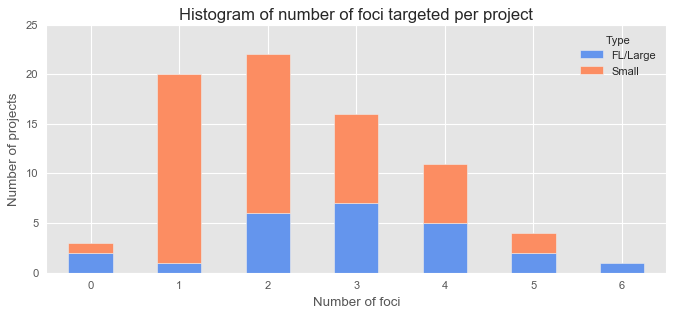

In [18]:
df_focus['total foci'] = df_focus[categories+["Other"]].sum(axis=1).astype(int)
table = df_focus.groupby('total foci')['Type'].value_counts().unstack()
table.plot(kind='bar',stacked=True)
ax = plt.subplot();ax.set_xlabel('Number of foci',fontsize=12);ax.set_ylabel('Number of projects',fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation='horizontal')
ax.set_title("Histogram of number of foci targeted per project",fontsize=15);

In [19]:
table.index.names = ['Number of projects with certain number of foci']
table.fillna(0).to_excel(writer, sheet_name = 'projects_per_number_foci')

It seems like a few projects have no foci... here they are below:

In [20]:
df_focus[df_focus['total foci']==0]

,PROJECT ID,Resource development (e.g. media; open resources; reading and PD materials; learning modules; apps),Infrastructure development (e.g. LMS; repositories; physical spaces),Pedagogies for student learning and/or engagement (e.g. flipped classroom; active learning; student-generated content; student choice; peer-collaboration),Teaching roles and training (e.g. co-teaching; TA roles; office hours; participation in PD),Curriculum and design (e.g. learning/course/program design; cross and trans disciplinary courses/programs; formulation of course/program learning outcomes),Innovative assessment (e.g. two-stage exams; peer-assessment; engaging assessments; student choice),Community outreach and values (e.g. community service; social networks; co-op; social inclusion and equity; indigenous; wellbeing),Test category,Other,Faculty,Type,Year,Funds received,Evaluation TLEF $ Asks,total foci
6,2013FL1_ARTS_ISIT_Cutler,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ARTS,FL/Large,2013,197000.0,None,0
20,2013FL1_LFS_APBI_Krzic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LFS,FL/Large,2013,46430.0,None,0
46,14-004 Balanko,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,APSC,Small,2014,88600.0,None,0


Also, many projects have 4 or 5 foci... maybe these projects are to big for their own good? We can investigate this later looking at funding allocated and level of evidence they reported.

## What do project typically focus on?

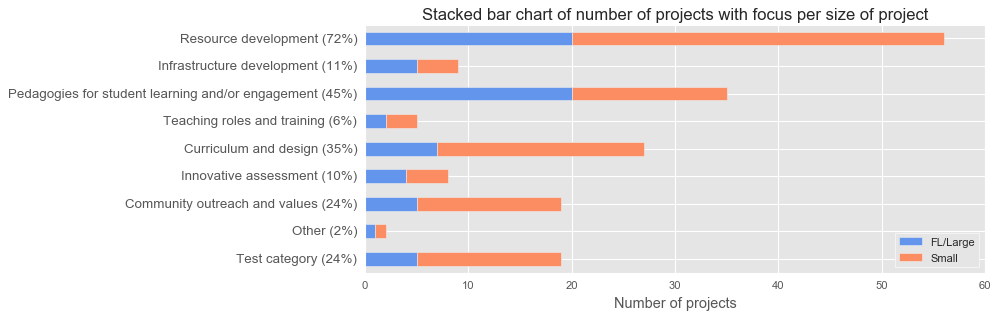

In [21]:
def get_cat_type(row,c):
    if row[c]==1: return row['Type']
    else: return np.nan
    
for c in categories:
    df_focus[c+'_type'] = df_focus.apply(lambda row: get_cat_type(row,c),axis=1)
table = df_focus[[c+"_type" for c in categories]].apply(lambda x: x.value_counts()).transpose().iloc[::-1,:]
table.plot.barh(stacked=True)
ax = plt.subplot()
ax.legend(loc=4,frameon=True);ax.set_xlabel('Number of projects',fontsize=13)
ax.set_yticklabels(reversed([c + " ("+str(int(float(df_focus[df_focus[categories[i]]==1].shape[0])/N*100))+"%)" for i,c in enumerate(short_categories)]),fontsize=12);
ax.set_title("Stacked bar chart of number of projects with focus per size of project",fontsize=15);

In [22]:
table.index = [i.replace("_type","") for i in table.index]
table.index.names = ['Number of projects per focus category']
table.fillna(0).to_excel(writer, sheet_name = 'projects_per_category')

## What levels of evidence are reported by how many projects?
(for impact on both people and processes)

In [23]:
objects = ["Student learning and knowledge",
    "Student engagement and attitudes",
    "Instructional team teaching practice and satisfaction",
    "Other",
    "Operations & Department capacity",
    "Influence in priorities/direction ",
    "Other"]

df_evidence['has evidence'] = df_evidence[objects].apply(pd.Series.value_counts, axis=1)[["Evidence"]].fillna(0)
df_evidence['has anecdotal'] = df_evidence[objects].apply(pd.Series.value_counts, axis=1)[["Anecdotal"]].fillna(0)
df_evidence['has no impact'] = df_evidence[objects].apply(pd.Series.value_counts, axis=1)[["No impact"]].fillna(0)
df_evidence['has no information'] = df_evidence[objects].apply(pd.Series.value_counts, axis=1)[["No information"]].fillna(0)
df_evidence['binary has evidence'] = (df_evidence['has evidence'] > 0).astype(int)
df_evidence['binary has anecdotal'] = (df_evidence['has anecdotal'] > 0).astype(int)
df_evidence['binary has no impact']= (df_evidence['has no impact'] > 0).astype(int)
df_evidence['binary has no information']= (df_evidence['has no information'] > 0).astype(int)

df_evidence['Type'] = df_evidence['PROJECT ID'].apply(lambda x: list(df_focus[df_focus['PROJECT ID']==x]['Type'])[0])

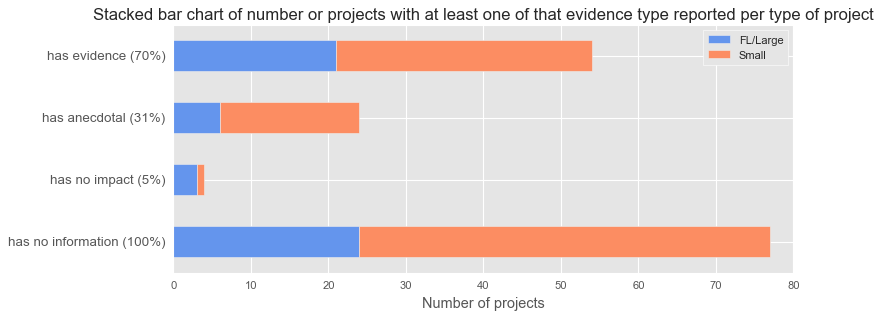

In [24]:
evidence_levels = ['has evidence','has anecdotal','has no impact','has no information']
def get_evidence_type(row,e):
    if row[e]>=1: return row['Type']
    else: return np.nan
    
for e in evidence_levels:
    df_evidence[e+'_type'] = df_evidence.apply(lambda row: get_evidence_type(row,e),axis=1)
table = df_evidence[[e+"_type" for e in evidence_levels]].apply(lambda x: x.value_counts()).transpose().iloc[::-1,:]
table.plot.barh(stacked=True)
ax = plt.subplot()
ax.legend(loc=1,frameon=True);ax.set_xlabel('Number of projects',fontsize=13)
ax.set_yticklabels(reversed(evidence_levels),fontsize=13)
ax.set_yticklabels(reversed([e + " ("+str(int(float(df_evidence[df_evidence['binary '+e]==1].shape[0])/N*100))+"%)" for i,e in enumerate(evidence_levels)]),fontsize=12);
ax.set_title("Stacked bar chart of number or projects with at least one of that evidence type reported per type of project",fontsize=15);

In [25]:
table.index = [i.replace("_type","") for i in table.index]
table.index.names = ['Number of projects with at least one of that type of evidence reported']
table.fillna(0).to_excel(writer, sheet_name = 'projects_per_evidence')

Many projects report evidence for at least one impact. That's very promising!
It seems like large projects are more likely than small projects to report evidence, but less likely to report anecdotal evidence.

Of those that don't report evidence, do they at least report anecdotal evidence or no impact?

In [26]:
t = []
df_evidence_NONE = df_evidence[df_evidence['binary has evidence']==0]
N_NONE = len(df_evidence_NONE)
t.append(["evidence",int(df_evidence_NONE['binary has evidence'].sum()),str(int(float(df_evidence_NONE['binary has evidence'].sum())/N_NONE*100))+"%"])
t.append(["anecdotal",int(df_evidence_NONE['binary has anecdotal'].sum()),str(int(float(df_evidence_NONE['binary has anecdotal'].sum())/N_NONE*100))+"%"])
t.append(["no impact",int(df_evidence_NONE['binary has no impact'].sum()),str(int(float(df_evidence_NONE['binary has no impact'].sum())/N_NONE*100))+"%"])
t.append(["no information",int(df_evidence_NONE['binary has no information'].sum()),str(int(float(df_evidence_NONE['binary has no information'].sum())/N_NONE*100))+"%"])
print(tabulate(t,headers=['Type of evidence','Number of projects from '+str(N_NONE)+' that have NO evidence, how many have this evidence','Percentage']))

Type of evidence      Number of projects from 23 that have NO evidence, how many have this evidence  Percentage
------------------  -------------------------------------------------------------------------------  ------------
evidence                                                                                          0  0%
anecdotal                                                                                         9  39%
no impact                                                                                         0  0%
no information                                                                                   23  100%


Of those that never report evidence, only 39% provide anecdotal...

So that leaves (23-9=) 14 projects with neither evidence nor anecdotal evidence. Here they are below:

In [27]:
projects_with_no_evidence = [str(x) for x in list(df_evidence_NONE[df_evidence_NONE['binary has anecdotal']==0]['PROJECT ID'])]

In [28]:
table = pd.DataFrame(t)
table.columns=['type of evidence',' Of those with NO evidence, how many projects have this evidence','Percentage']
table.to_excel(writer, sheet_name = 'projects_NO_evidence')

## How many areas of impact to projects typically report evidence for?

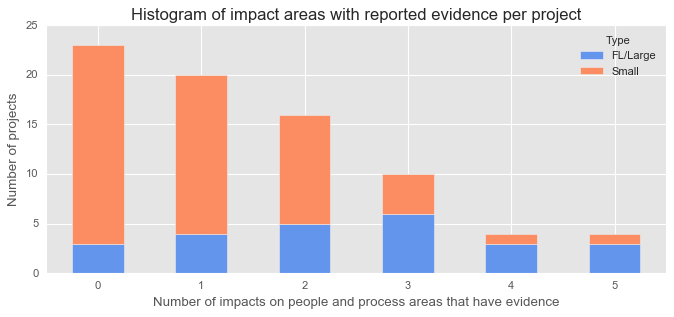

In [29]:
table = df_evidence.groupby('has evidence')['Type'].value_counts().unstack()
table.plot(kind='bar',stacked=True)
ax = plt.subplot();ax.set_xlabel('Number of impacts on people and process areas that have evidence',fontsize=12);ax.set_ylabel('Number of projects',fontsize=12)
ax.set_xticklabels([int(x) for x in ax.get_xticks()],rotation='horizontal')
ax.set_title("Histogram of impact areas with reported evidence per project",fontsize=15);

In [30]:
table.index.names = ["Number of impacts on people and process areas that have evidence"]
table.fillna(0).to_excel(writer, sheet_name = 'projects_per_evidence')

Evidence can be reported for 7 different areas (related to impacts on people and process). Many project do not report evidence for any of these areas. A few report evidence for over 3 different areas.

# Finding patterns between projects focus and reported evidence

## What focus areas are often jointly targeted by a project?

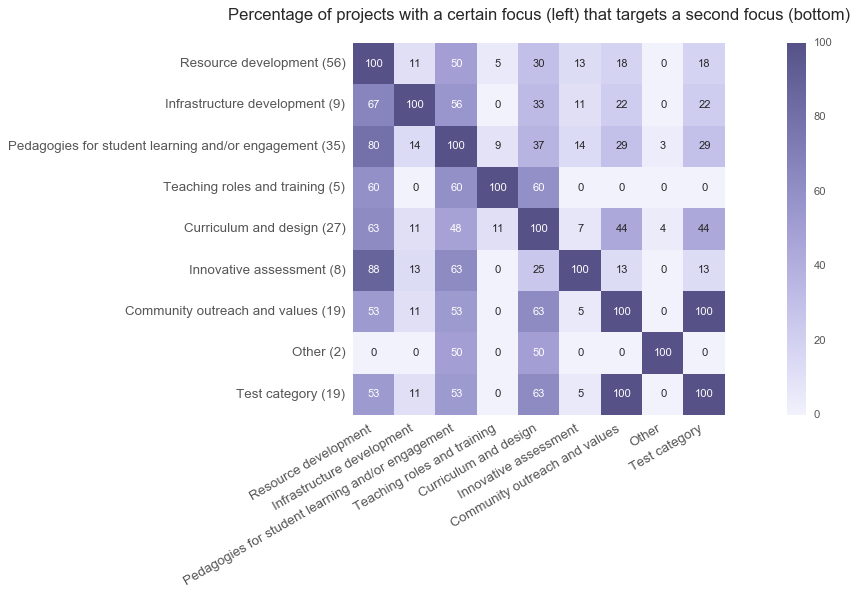

In [31]:
data_cats = np.zeros((len(categories),len(categories)))
for i,ci in enumerate(categories):
    for j,cj in enumerate(categories):
        data_cats[i,j] = round(float(df_focus[(df_focus[ci]==1)&(df_focus[cj]==1)][cj].sum())/df_focus[df_focus[ci]==1].shape[0]*100,0)
            #normalize by number of projects for that category
df_cats = pd.DataFrame(data_cats,columns=categories)
fig, ax = plt.subplots(figsize=(20,6))
# mask = np.zeros_like(data_cats)
# mask[np.triu_indices_from(mask)] = True
sns.heatmap(data_cats, ax=ax, square=True, yticklabels=short_categories,annot=True,cmap=seq_palette, fmt='g')
ax.set_title("Percentage of projects with a certain focus (left) that targets a second focus (bottom)\n",fontsize=15)
ax.set_xticklabels(short_categories,rotation=30,ha='right',fontsize=12)
ax.set_yticklabels(reversed([c + " ("+str(df_focus[df_focus[categories[i]]==1].shape[0])+")" for i,c in enumerate(short_categories)]),fontsize=12);
# ax.set_yticklabels(reversed(short_categories),fontsize=12);

In [32]:
table = pd.DataFrame(data_cats)
table.columns = short_categories
table.index = short_categories
table.index.names = ["Percentage of projects with a certain focus (left) that targets a second focus (top)"]
table.to_excel(writer, sheet_name = 'joint_focus_categories')

There are some interesting patterns to notice here. For example, of the projects focusing on resource development, 50% also focus on Pedagogies. However of projects focusing on Pedagogies, 80% also do resource development. Clearly some foci are targeted comonly by most projects (Resource, Pedagogies and Curriculum design) when other foci are present though these three foci are also targeted on their own.

## What kind of evidence is reported per area of impact?

In [33]:
types_evidence = [
    "Student engagement and attitudes",
    "Student learning and knowledge",
    "Instructional team teaching practice and satisfaction",
    "Operations & Department capacity",
    "Influence in priorities/direction ",
    "Other",
    "Other.1"
]
types_evidence_names = [
    "Student engagement and attitudes",
    "Student learning and knowledge",
    "Instructional team teaching practice and satisfaction",
    "Operations & Department capacity",
    "Influence in priorities/direction ",
    "Other (impact to people)",
    "Other (impact to processes)"
]

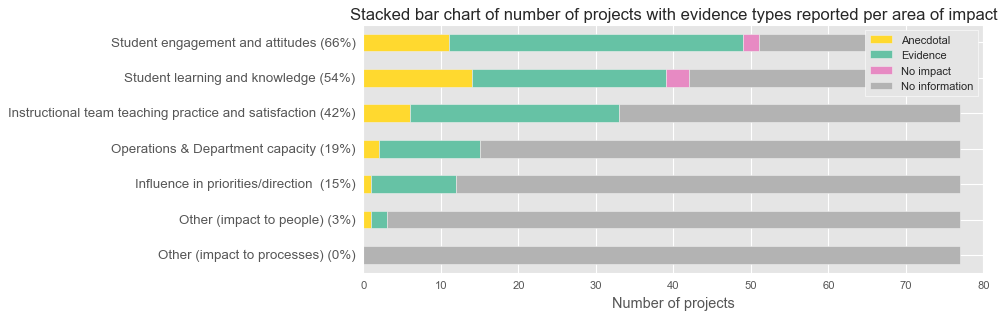

In [34]:
table = df_evidence[types_evidence].apply(lambda x: x.value_counts()).transpose().iloc[::-1,:]
table.plot.barh(stacked=True,color = reversed(CMAP[3:]))
ax = plt.subplot()
ax.legend(loc=1,frameon=True);ax.set_xlabel('Number of projects',fontsize=13)
ax.set_yticklabels(reversed(types_evidence_names),fontsize=13)
ax.set_yticklabels(reversed([e + " ("+str(int(float(df_evidence[df_evidence[types_evidence[i]]!='No information'].shape[0])/N*100))+"%)" for i,e in enumerate(types_evidence_names)]),fontsize=12);
ax.set_title("Stacked bar chart of number of projects with evidence types reported per area of impact",fontsize=15);

In [35]:
table.index.names = ['Number of projects with evidence types reported per area of impact']
table.fillna(0).to_excel(writer, sheet_name = 'projects_per_evidence_impact')

Clearly evidence is reported more for some areas of intended impact than others. It's important to remember that "No information" means either that area was not intended to be impacted by a project, or it was and no evidence was reported that there indeed was an impact.

Since very few projects report "No impact", it might be worth merging this category into "Anecdotal" or "Evidence" as appropriate. 

## What project foci are related to reporting evidence for certain impact areas?
Are there any noticeable patterns when it comes to focus targeted and evidence collected in certain areas?

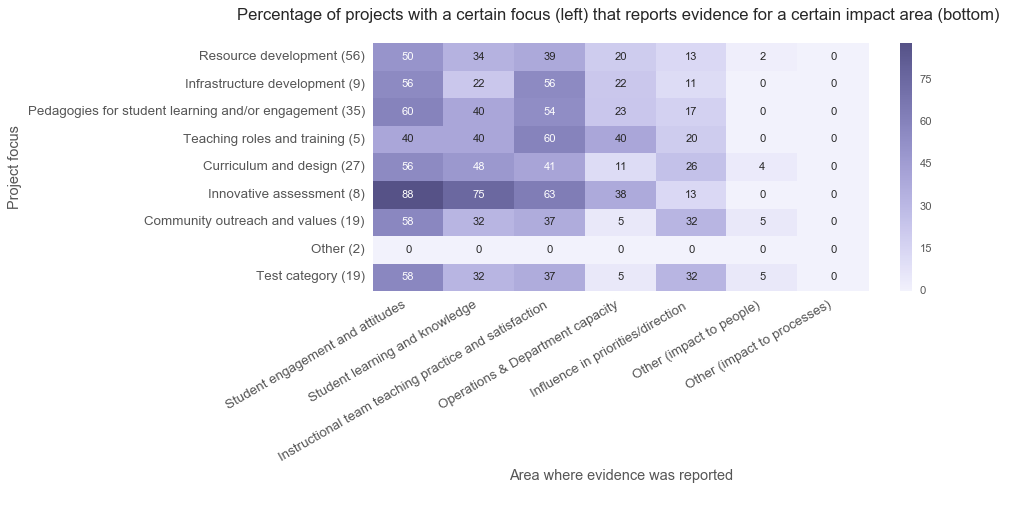

In [36]:
data_cats_evi = np.zeros((len(categories),len(types_evidence)))
for i,ci in enumerate(categories):
    for j,cj in enumerate(types_evidence):
        #projects for that category
        projects = list(df_focus[df_focus[ci]==1]['PROJECT ID'])
        #number of projects for that category and that area where evidence was found
        num = df_evidence[(df_evidence['PROJECT ID'].isin(projects))&(df_evidence[cj]=='Evidence')].shape[0]
        data_cats_evi[i,j] = round(float(num)/df_focus[df_focus[ci]==1].shape[0]*100,0) #normalize by number of projects for that category
#         data_cats_evi[i,j] = int(num)
ax = sns.heatmap(data_cats_evi, yticklabels=short_categories, annot=True, cmap=seq_palette)
ax.set_xticklabels(types_evidence_names,rotation=30,ha='right',fontsize=12)
ax.set_yticklabels(reversed([c + " ("+str(df_focus[df_focus[categories[i]]==1].shape[0])+")" for i,c in enumerate(short_categories)]),fontsize=12);
ax.set_xlabel('Area where evidence was reported\n',fontsize=13);ax.set_ylabel('Project focus',fontsize=13)
ax.set_title("Percentage of projects with a certain focus (left) that reports evidence for a certain impact area (bottom) \n",fontsize=15);

In [37]:
table = pd.DataFrame(data_cats_evi)
table.columns = types_evidence_names
table.index = short_categories
table.index.names = ["Percentage of projects with a certain focus (left) that reports evidence for a certain impact area (top)"]
table.to_excel(writer, sheet_name = 'joint_focus_impact_categories')

Some patterns we can see:

* Many projects that focus on *Resource development* report evidence in *Student learning* (34%  of projects with that focus), *Student engagement* (50%) and *Instructional teaching practices* (39%).


* Looking at projects focusing on *Pedagogies for student learning* we see that 40% report evidence on *Student learning and knowledge*.


* Looking at projects focusing on *Teaching roles and training* we see that 60% report evidence on *Instructional team teaching practice and satisfaction*.


* Another interesting pattern is that of the projects that conduct "Innovative assessment", 88% (7/8) report evidence on Student engagement and attitudes and 75% (6/8) report evidence on Student learning and Knowledge. Quite a promising result!

#  Finding patterns between projects' funding and their foci and evidence

We may want to consider splitting projects into low, medium, and high funding groups

##  How much funding does a project with different number of foci typically get?

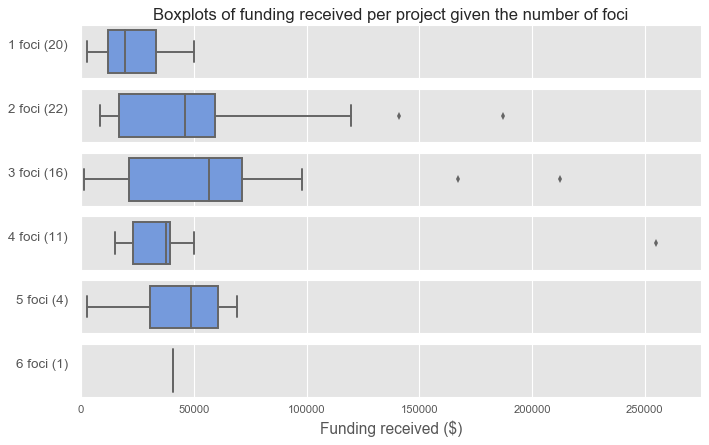

In [38]:
df_focus['total foci'] = df_focus[categories+["Other"]].sum(axis=1)
F = int(max(df_focus['total foci']))
fig,axes = plt.subplots(nrows=F,ncols=1,figsize=(10,6))
for ax,n_foci in zip(axes,range(1,F+1)):
    sns.boxplot(df_focus[df_focus['total foci']==n_foci]['Funds received'],ax=ax);
    ax.set_xlabel('');ax.set_ylabel('{0} foci ({1})'.format(n_foci,df_focus[df_focus['total foci']==n_foci].shape[0]),rotation='horizontal',ha='right',fontsize=12);
    ax.set_xlim((0,275000))
    if n_foci!=F:
        ax.set_xticklabels([])

ax.set_xlabel('Funding received ($)',fontsize=14);
axes[0].set_title("Boxplots of funding received per project given the number of foci",fontsize=15);

## Do certain foci require more funding?

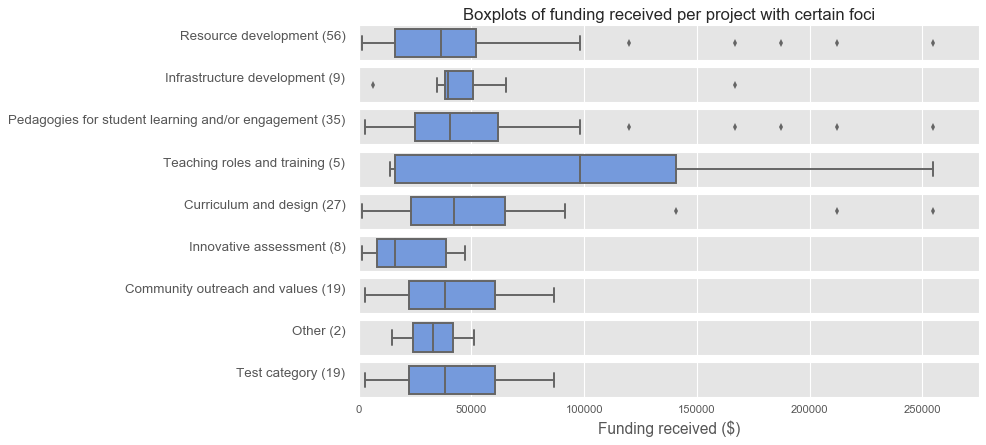

In [39]:
fig,axes = plt.subplots(nrows=len(categories),ncols=1,figsize=(10,6))
for i,(ax,c_i) in enumerate(zip(axes,categories)):
    sns.boxplot(df_focus[df_focus[c_i]==1]['Funds received'],ax=ax);
    ax.set_xlabel('');ax.set_ylabel(short_categories[i]+ " ("+str(df_focus[df_focus[c_i]==1].shape[0])+")",
                                    rotation='horizontal',ha='right',fontsize=12);

    ax.set_xlim((0,275000))
    if i!=len(categories)-1:
        ax.set_xticklabels([])

ax.set_xlabel('Funding received ($)',fontsize=14);
axes[0].set_title("Boxplots of funding received per project with certain foci",fontsize=15);

There doesn't seem to be an obvious pattern here. Projects focusing on Innovative assessment tend to be cheaper but projects with the other foci are quite similar in funding. There are too few projects (5) focusing on Teaching roles and training to really draw a conclusion on funding for that focus.

## Do certain intended areas of impact require more funding?

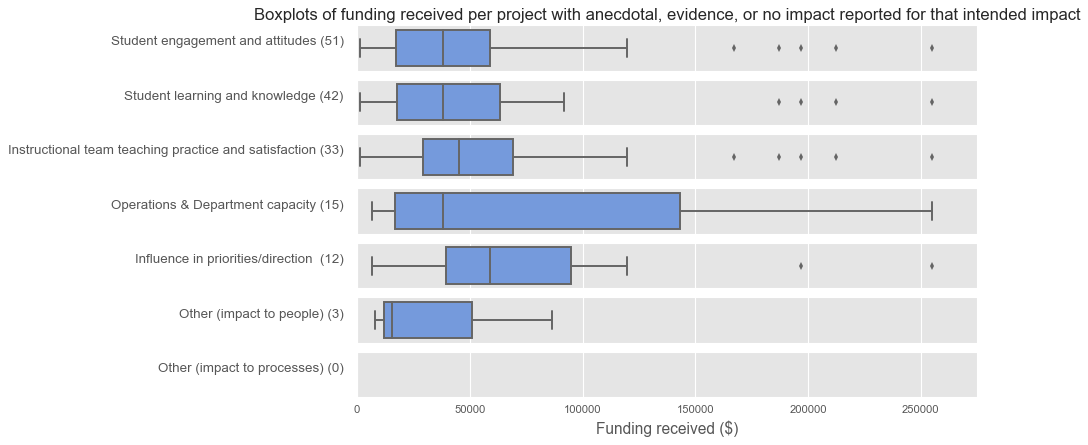

In [40]:
fig,axes = plt.subplots(nrows=len(types_evidence),ncols=1,figsize=(10,6))
for i,(ax,t_i) in enumerate(zip(axes,types_evidence)):
    projects = list(df_evidence[df_evidence[t_i]!='No information']['PROJECT ID'])
    #number of projects with evidence for that impact
    sns.boxplot(df_focus[(df_focus['PROJECT ID'].isin(projects))]['Funds received'],ax=ax);
    ax.set_xlabel('');ax.set_ylabel(types_evidence_names[i]+ " ("+str(len(projects))+")",rotation='horizontal',ha='right',fontsize=12);
    ax.set_xlim((0,275000))
    if i!=len(types_evidence)-1:
        ax.set_xticklabels([])

ax.set_xlabel('Funding received ($)',fontsize=14);
axes[0].set_title("Boxplots of funding received per project with anecdotal, evidence, or no impact reported for that intended impact",fontsize=15);

No obvious patterns here. Possibly projects intending to impact Operations cost more.

Let's redo the same plot this time looking at projects that report Evidence (not anecdotal or no impact) for that intended impact

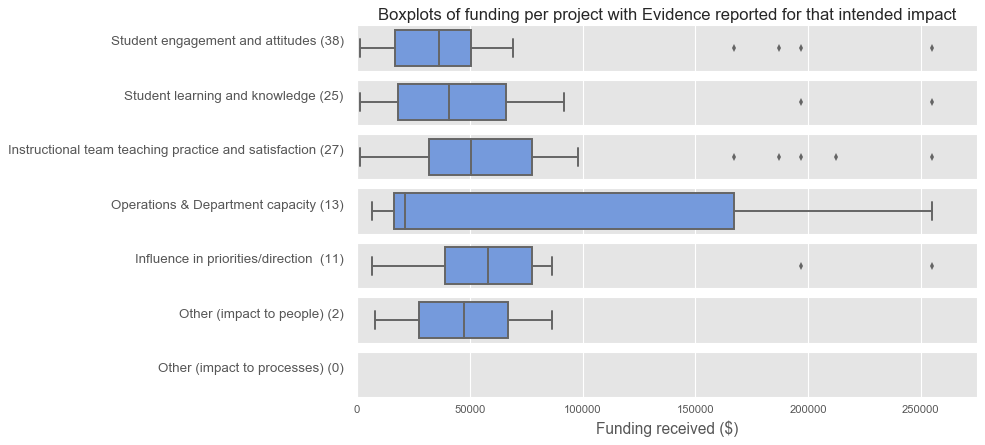

In [41]:
fig,axes = plt.subplots(nrows=len(types_evidence),ncols=1,figsize=(10,6))
for i,(ax,t_i) in enumerate(zip(axes,types_evidence)):
    projects = list(df_evidence[df_evidence[t_i]=='Evidence']['PROJECT ID'])
    #number of projects with evidence for that impact
    sns.boxplot(df_focus[(df_focus['PROJECT ID'].isin(projects))]['Funds received'],ax=ax);
    ax.set_xlabel('');ax.set_ylabel(types_evidence_names[i]+ " ("+str(len(projects))+")",rotation='horizontal',ha='right',fontsize=12);
    ax.set_xlim((0,275000))
    if i!=len(types_evidence)-1:
        ax.set_xticklabels([])

ax.set_xlabel('Funding received ($)',fontsize=14);
axes[0].set_title("Boxplots of funding per project with Evidence reported for that intended impact",fontsize=15);

Clearly there are 6 super expensive porject that try to do a lot. Let's pull these out:

In [42]:
df_focus.sort_values('Funds received',inplace=True)
df_focus[-6:]

,PROJECT ID,Resource development (e.g. media; open resources; reading and PD materials; learning modules; apps),Infrastructure development (e.g. LMS; repositories; physical spaces),Pedagogies for student learning and/or engagement (e.g. flipped classroom; active learning; student-generated content; student choice; peer-collaboration),Teaching roles and training (e.g. co-teaching; TA roles; office hours; participation in PD),Curriculum and design (e.g. learning/course/program design; cross and trans disciplinary courses/programs; formulation of course/program learning outcomes),Innovative assessment (e.g. two-stage exams; peer-assessment; engaging assessments; student choice),Community outreach and values (e.g. community service; social networks; co-op; social inclusion and equity; indigenous; wellbeing),Test category,Other,Faculty,Type,Year,Funds received,Evaluation TLEF $ Asks,total foci,Resource development (e.g. media; open resources; reading and PD materials; learning modules; apps)_type,Infrastructure development (e.g. LMS; repositories; physical spaces)_type,Pedagogies for student learning and/or engagement (e.g. flipped classroom; active learning; student-generated content; student choice; peer-collaboration)_type,Teaching roles and training (e.g. co-teaching; TA roles; office hours; participation in PD)_type,Curriculum and design (e.g. learning/course/program design; cross and trans disciplinary courses/programs; formulation of course/program learning outcomes)_type,Innovative assessment (e.g. two-stage exams; peer-assessment; engaging assessments; student choice)_type,Community outreach and values (e.g. community service; social networks; co-op; social inclusion and equity; indigenous; wellbeing)_type,Other_type,Test category_type
56,14-087-Loewen-Final,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,PHAR,Small,2014,140936.0,10000,2.0,NaN,NaN,NaN,Small,Small,NaN,NaN,NaN,NaN
4,2013FL1_ARTS_LING_Matthewson,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ARTS,FL/Large,2013,167022.0,TLF,3.0,FL/Large,FL/Large,FL/Large,NaN,NaN,NaN,NaN,NaN,NaN
14,2013FL1_SCIE-EOAS-Harris,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,SCIE,FL/Large,2013,187353.0,TLF,2.0,FL/Large,NaN,FL/Large,NaN,NaN,NaN,NaN,NaN,NaN
6,2013FL1_ARTS_ISIT_Cutler,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ARTS,FL/Large,2013,197000.0,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013FL1_COMM_Bemmels,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,COMM,FL/Large,2013,212240.0,TLF,3.0,FL/Large,NaN,FL/Large,NaN,FL/Large,NaN,NaN,NaN,NaN
1,2013FL1_APSC_NURS_Macphee,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,APSC,FL/Large,2013,254808.0,TLF,4.0,FL/Large,NaN,FL/Large,FL/Large,FL/Large,NaN,NaN,NaN,NaN


# Modeling the "return on investment"

We want to try to predict the likelihood of a project reporting evidence (yes or no) given it's type (small/large) and funds received. (We don't have enough data to including the project foci in our model).

In [43]:
df_focus['funding'] = df_focus['Funds received']
df_focus['evidence'] = df_focus['PROJECT ID'].apply(lambda x: list(df_evidence[df_evidence['PROJECT ID']==x]['binary has evidence'])[0])
for c in categories:
    df_focus[c.split(' ')[0]] = df_focus[c]

In [44]:
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit

In [45]:
formula = 'evidence ~ Type + funding'
# print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, df_focus, return_type = 'dataframe')
logit = Logit(Y, X)
model = logit.fit(maxiter=100)
model.summary()

Optimization terminated successfully.
         Current function value: 0.572441
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               evidence   No. Observations:                   77
Model:                          Logit   Df Residuals:                       74
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Jun 2018   Pseudo R-squ.:                 0.06120
Time:                        15:35:05   Log-Likelihood:                -44.078
converged:                       True   LL-Null:                       -46.952
                                        LLR p-value:                   0.05650
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         2.1870      0.857      2.553      0.011         0.508     3.866
Type[T.Small]    -1.5903      0.774     -2.054      0.040        -3.108    -0.073
funding       -2.802e-06   6.49e-06     -0.432      0.666     -1.55e-05  9.92e-06
=================================================================================
"""

When the project type is Large, there is an increased likelihood to get reported evidence.

The funds received by the project are not related to the likelihood of evidence reported.

### Export tables

In [46]:
writer.save()

In [47]:
writer.close()